In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
from ummalqura.hijri_date import HijriDate
from datetime import date, datetime
from IPython.display import display
import os
from selenium.webdriver.support.ui import Select
from datetime import datetime
from IPython.display import Image, display
from operator import is_not
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

# Web Scrapping - Hassa

Initiate a WebDriver that will connect to [AlHasa Municipality](https://www.alhasa.gov.sa/SitePages/GetObituary.aspx) website

In [ ]:
def connect():
    #launch url
    url = 'https://www.alhasa.gov.sa/SitePages/GetObituary.aspx'

    # create a new Firefox session
    driver = webdriver.Firefox()
    driver.implicitly_wait(5)
    driver.get(url)
    return driver

Because the date pickers in this website are complex, and the website doesn't allow me to write on the dates text field directly, I choose to set the dates manually.

The loop below iterates through the pages, and only stores the source code of each page. I separated the data structuring phase to a separate loop because I don't want to interrupt or add delay to the web scrapping part.

In [ ]:
page_sources = []
while True:
    page_sources.append(driver.page_source)
    try:
        next_btn = driver.find_element_by_id(
        'ctl00_SPWebPartManager1_g_f82b5b79_188a_4cdc_a21b_8d289061bf26_ctl00_Pager_LbNext')
        next_btn.click()
    except:
        break
    

The loop below will iterate through `page_sources`, which was collected in the previous loop, and get the data from the table of each page, then store them in a dataframe

In [ ]:
people = []
for page_source in page_sources:
    soup = BeautifulSoup(page_source,'lxml')
    table = soup.find('div',
                      {'id':
                       'ctl00_SPWebPartManager1_g_f82b5b79_188a_4cdc_a21b_8d289061bf26_ctl00_ROW_MULTIDATA'})
    table = (list(table.children))[1]
    table = (list(table.children))[1]
    table = (list(table.children))[1]
    table = (list(table.children))[1:]

    for p in table:
        try:
            person = (list(p.children))[1:-1]
            person = [x.text.replace('\n','') for x in person]
            people.append(person)
        except:
            continue
column_names = ['Name','Gender','Nationality','Age','Date of Burial','Hospital','Permit Number']
df = pd.DataFrame(people,columns=column_names)

Finally, the web scrapping part is completed anda all the data that we need are in the dataframe above

## Data Preprocessing

In [2]:
df = pd.read_csv('data/Hassa_deaths_records.csv',index_col=0)

### Helper Fucntions

In [3]:
# Change Date from and to Gregorian
def toGr(hj):
    try:
        hjr = hj.split('/')
        hjr = HijriDate(int(hjr[0]), int(hjr[1]), int(hjr[2]))
    except:
        raise Exception(hj)
    return pd.to_datetime('{} {} {}'.format(hjr.year_gr,hjr.month_name_gr,hjr.day_gr))
def toHj(gr):
    return HijriDate(gr.year,gr.month,gr.day,gr=True)

### Data Cleaning and Transformation

In [4]:
# Add a column with Gregorian dates
df['Date of Burial Gr'] = df['Date of Burial'].apply(toGr)

#Change the type of the Age from Object to Integers. Fraction ages will be rounded
df['Age'] = df['Age'].apply(lambda x: 0. if (x == 'أقل من سنة ')  else int(float(x))
                           )
# Encode the Genders to Female and Male
df['Gender'] = df['Gender'].apply(lambda x: 'M' if x == 'ذكر' 
                                  else 'F' if x == 'انثى' 
                                  else np.nan)

# Dropped Rows condtions:
##- Rows with unknown gender
##- Rows with Ages above 100 and below 5
##- Rows of None Saudi people
drop_condtions = (df.Gender.isna()) | (df['Age']>100)|(df['Age']<5) | (df.Nationality!='سعودي')
df.drop(df[drop_condtions].index,inplace=True)
# df.drop(df[df.Gender.isna()].index,inplace=True);
# df.drop(df[(df['Age']>100)|(df['Age']<5)].index,inplace=True);

# Drop duplicate rows
df.drop_duplicates(keep='first',inplace=True)

## Data Exploration

In [5]:
print('Mean age =',round(df.Age.mean()))
print('Female to Male ratio = {:.0f}:{:.0f}'.format(
    10*df[df.Gender == 'F'].shape[0]/df.shape[0],
    10*df[df.Gender == 'M'].shape[0]/df.shape[0]))


Mean age = 62.0
Female to Male ratio = 4:6


### Check Data Completion
It is highly unlikely that a day would pass without any deaths in any region in Saudi Arabia. However, while I was scrapping the data, I have noticed that there some gaps between records, some spanning to days, weeks, or even months. That's why I have done the following analysis to explore patterns in the missing data

- The percentage of days without records in the data set = %56.48
- Total number of days without records = 1738


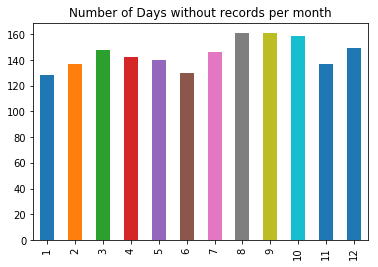

8     161
9     161
10    159
12    149
3     148
7     146
4     142
5     140
2     137
11    137
6     130
1     128
dtype: int64

In [6]:
#Array of days with records in the dataset
days = np.sort(df['Date of Burial Gr'].unique())
existing_days_per_month = pd.Series(days).apply(lambda x: toHj(x).month).value_counts()
#Number of days between the first record and the last
days_dif = pd.Timedelta((days[-1]-days[0])).days
#Get the total days object from the date of the first record to the last
days_range = (pd.date_range(days[0], periods=days_dif+1).values)

#Array of days with in the range, but with no records in the dataset
missing_days = np.array(list(set(days_range).difference(set(days))))
missing_days_per_month = pd.Series(missing_days).apply(lambda x: toHj(x).month).value_counts()

print('- The percentage of days without records in the data set = %{:.2f}'
      .format(100*len(missing_days)/days_range.shape[0]))
print('- Total number of days without records =',len(missing_days))

plt.title('Number of Days without records per month')
(missing_days_per_month.sort_index()).plot.bar();
plt.show()


missing_days_per_month.sort_values(ascending=False)

**Observation**: The number of days without records is not uniformly distributed throughout the months, therefore, seasonal trends is affected by the missing data. Furthermore, it is safe to assume that even the recorded days have missing records with in them. That is why I believe that the data aquired from [AlHasa Municipality](https://www.alhasa.gov.sa/SitePages/GetObituary.aspx) is unreliable

### Moment of Truth
The purpose of this analysis is to determine whether Shaban(the 8th Hijir month) was the month in which muslims die the most. The bar chart below Tells us otherwise

In [7]:
#All
record_per_month = df['Date of Burial'].apply(lambda x: x.split('/')[1]).value_counts()
record_per_month = (record_per_month*100/df.shape[0]).round(2).sort_index()
#M
record_per_month_M = df[df['Gender']=='M']['Date of Burial'].apply(lambda x: x.split('/')[1]).value_counts()
record_per_month_M = (record_per_month_M*100/df[df['Gender']=='M'].shape[0]).round(2).sort_index()
#F
record_per_month_F = df[df['Gender']=='F']['Date of Burial'].apply(lambda x: x.split('/')[1]).value_counts()
record_per_month_F = (record_per_month_F*100/df[df['Gender']=='F'].shape[0]).round(2).sort_index()
rpm_df = pd.DataFrame(list(zip(record_per_month_M,record_per_month_F,record_per_month)),
                     columns =['M','F','All'],index = record_per_month.index)


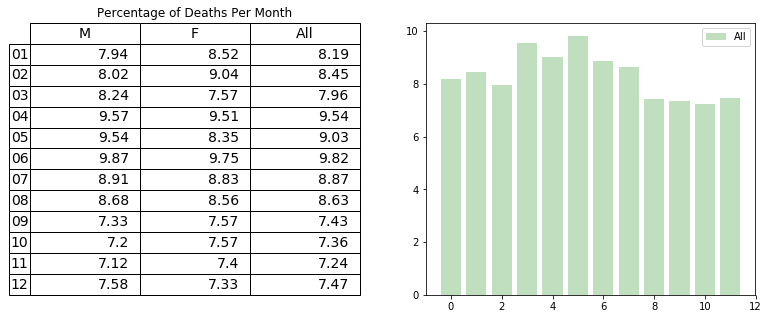

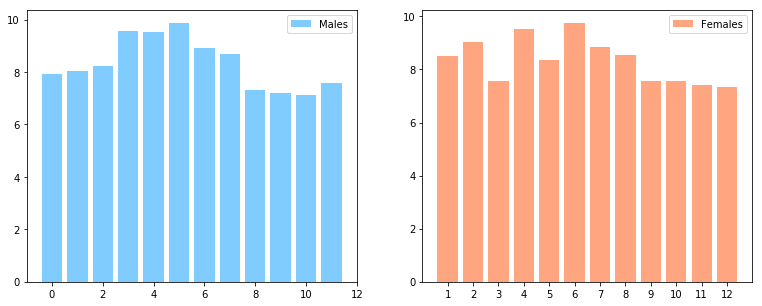

,M,F,All
Month Rank,,,
1,06,06,06
2,04,04,04
3,05,02,05
4,07,07,07
5,08,08,08
6,03,01,02
7,02,05,01
8,01,10,03
9,12,09,12


In [8]:
# Make a fake dataset
fig = plt.figure(figsize=(13,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

height = record_per_month.sort_index().values
bars = list(range(1,13))
y_pos = np.arange(len(bars))

ax2.bar(y_pos, height, color='g',alpha=.25,label='All',)
ax2.legend()

font_size=14
bbox=[0, 0, 1, 1]
ax1.axis('off')
mpl_table = ax1.table(cellText = rpm_df.values, rowLabels = rpm_df.index, bbox=bbox,
                      colLabels=rpm_df.columns)

mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)
ax1.set_title('Percentage of Deaths Per Month')
plt.show()




fig = plt.figure(figsize=(13,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

height = record_per_month_M.sort_index().values
bars = list(range(1,13))
y_pos = np.arange(len(bars))
ax1.bar(y_pos, height, color=(.5,.8,1.),alpha=1,label='Males')
ax1.legend()

height = record_per_month_F.sort_index().values
bars = list(range(1,13))
y_pos = np.arange(len(bars))
ax2.bar(y_pos, height, color=(1., .65, .5),alpha=1,label='Females')
ax2.legend()

plt.xticks(y_pos, bars)
plt.show()


rank_m = rpm_df.M.sort_values(ascending=False).index
rank_f = rpm_df.F.sort_values(ascending=False).index
rank_all = rpm_df.All.sort_values(ascending=False).index
list(zip(rank_m,rank_f,rank_all))
rank = pd.DataFrame(list(zip(rank_m,rank_f,rank_all)),columns=rpm_df.columns,index=range(1,13))
rank.index.name = 'Month Rank'
display(rank)

# Web Scrapping - Riyadh [unsuccessful attempt]

I was a bit greedy for data, that's why I was trying to scrap data from the most populated reagion in the kingdom. The layout of the pages is [AlRiyadh Municipality's](https://www.alhasa.gov.sa/SitePages/GetObituary.aspx) website was designed very well. However, it is so buggy, which makes impossible to scrap without it being crashed 

In [ ]:
def connect():
    #launch url
    url = 'https://eservices.alriyadh.gov.sa/_layouts/RM_Pages/GRV/QueryDeaths.aspx'

    # create a new Firefox session
    driver = webdriver.Firefox()
    driver.implicitly_wait(5)
    driver.get(url)
    return driver

In [ ]:
driver = connect()

In [ ]:
%%time
people = []
page_sources = []
button_index = ['12','22','24']
j = -1
max_excepts = 3
while True:
    j = j +1
    sleep(2)
    try:
        page_source = driver.page_source
        soup = BeautifulSoup(page_source,'lxml')
        page_sources.append(page_source)
        
        script = "javascript:__doPostBack('ctl00$PlaceHolderMain$grdLeaves$ctl00$ctl03$ctl01$ctl{}','')".format(button_index[j%3])
        driver.find_element_by_xpath('//a[@href="{}"]'.format(script)).click()

        max_excepts = 3
        sleep(4)
    except:
        sleep(1)
        print('Except')
        max_excepts = max_excepts -1
        if max_excepts >=0:
            print('Refresh')
            driver.refresh()
        else:
            print('Error')
len((people))

In [ ]:
%%time
people = []
for page_source in page_sources:
        soup = BeautifulSoup(page_source,'lxml')

        #Scrap table rows
        rows = [soup.find('tr',{'id':('ctl00_PlaceHolderMain_grdLeaves_ctl00__'+str(i))}) for i in range(10)]
        rows = list(filter(partial(is_not, None), rows))
        rows = [list(r.children)[1:-1] for r in rows]
        for i,r in enumerate(rows):
            rows[i] = [i.text for i in r]
        people = people + rows
column_names = ['Nationality','Name','Reported By','Gender','Hospital','Date of Burial','Place of Burial']
df = pd.DataFrame(people,columns=column_names)
df.drop_duplicates(inplace=True)
df.to_csv('RYD.csv')